In [1]:
%pylab inline
import jax
import jax.numpy as np
%load_ext autoreload
%load_ext memory_profiler
%autoreload 2

import vbjax as nf

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
** shtns is not available


## Epileptor

Let's take the Epileptor model as an example, with an end goal of fitting some EEG style spectra.

In [4]:
x0 = np.zeros((6, 32))
nf.epi_dfun(x0, c=0, p=nf.epi_default_theta).shape

(6, 32)

so our dfun will automatically make use of vectors for state space, let's build a network model, just by composing a coupling function with the Jansen-Rit dfun

In [120]:
nn = 4
ns = np.tile(np.arange(nn),(nn,1))
key = jax.random.PRNGKey(42)
weights = jax.random.normal (key, (nn, nn))
lengths = jax.random.randint(key, (nn, nn), 0, 255)
buffer = jax.random.normal(key, (nn, lengths.max()+1))

def net_dfun(x, p):
    w, l, buf, mass_θ = p
    x1, y1, z, x2, y2, g = x
    lfp = x2 - x1
    # c = 1e-2 * np.sum(w*buffer[ns,l], axis=1)
    c = 1e-4 * np.dot(w, lfp)
    return nf.epi_dfun(x, c, mass_θ) 

x0 = np.zeros((6, nn))
net_θ = weights, lengths, buffer, nf.epi_default_theta
net_dfun(x0, net_θ).shape

(6, 4)

In [83]:
theta = nf.epi_default_theta._replace(x0=-2.2)
net_θ = weights, lengths, buffer, theta

now do a simulation,

In [92]:
theta

EpiTheta(I_rest1=3.1, I_rest2=0.45, gamma=0.01, tau_0=2857, tau_1=1, tau_2=10, x0=-2.2, y0=1)

In [90]:
_, loop = nf.make_sde(0.1, net_dfun, 1e-1)
key = jax.random.PRNGKey(0)
nt = 1024*10*2
x0 = np.zeros((6, nn))
x0 = x0.at[1].set(-5.0)

x0 = x0.at[2].set(np.r_[2.0, 2.5, 3.0, 3.5])       # set z differently per node

sigma = np.c_[0.025, 0.025, 0.0, 0.25, 0.25, 0]*0
zt = jax.random.normal(key, (nt, ) + x0.shape) * sigma.T
yt = loop(x0, zt, net_θ)
yt.shape

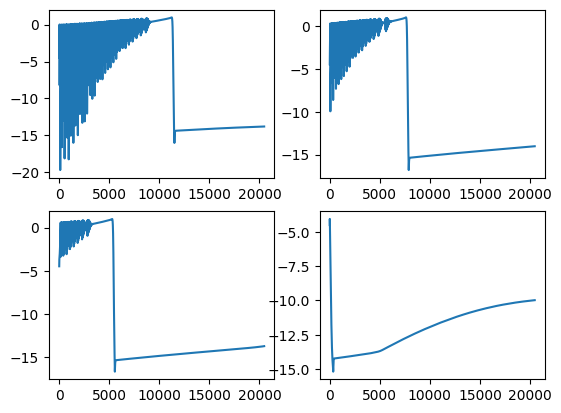

In [102]:
x1, y1, z, x2, y2, g = np.transpose(yt, (1,0,2))
lfp = x2 - x1
for i in range(4):
    subplot(2, 2, i + 1)
    # plot(lfp[:, i]);
    # plot(x2[:, i])
    # plot(y2[:, i])
    # plot(x1[:, i])
    plot(y1[:, i])
    # plot(z[:, i]); plot(g[:, i]); grid(1), ylim([-2.5, 5])

In [101]:
yt[-100:, :, 3].mean(axis=0)

Array([-1.4821365 , -9.984373  ,  2.961528  , -0.7189162 ,  0.24841589,
       -0.14883631], dtype=float32)

(Text(0.5, 0, 'x2'), Text(0, 0.5, 'y2'))

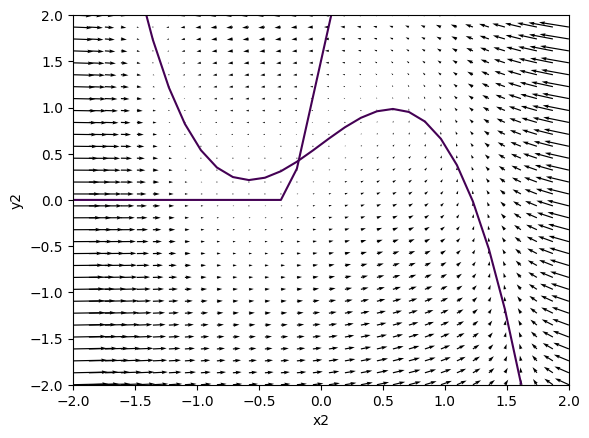

In [117]:
X,Y = np.mgrid[-2:2:32j, -2:2:32j]
X_, Y_ = X.reshape(-1), Y.reshape(-1)

# 
YS = np.c_[np.ones_like(X_) * (-1.5),
          np.ones_like(X_) * (-10.0),
          np.ones_like(X_) * 3.0,
          X_,
          Y_,
          np.ones_like(X_)*(-0.14)].T
YS.shape

_, _, _, dX, dY, _ = nf.epi_dfun(YS, 0, theta)

contour(X, Y, dX.reshape(X.shape), [0])
contour(X, Y, dY.reshape(X.shape), [0])
quiver(X, Y, dX.reshape(X.shape), dY.reshape(X.shape))
xlabel('x2'), ylabel('y2')

([<matplotlib.lines.Line2D at 0x2c2fa00a0>], None)

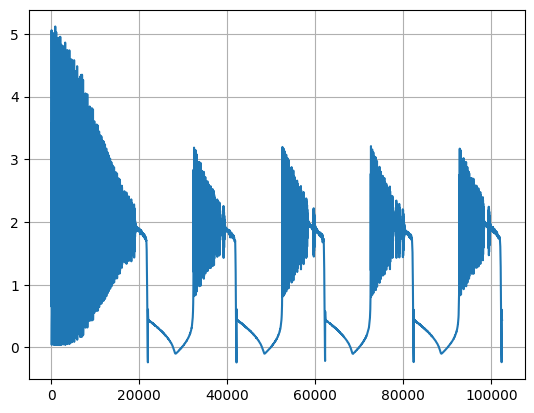

In [72]:
plot(x1[:,0] - (-1.6)), grid(1), 

In [7]:
%timeit loop(x0, zt, net_θ)

460 µs ± 2.54 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Now let's try a batch loop over initial conditions,

In [8]:
nb = 8
x0b = np.zeros((nb, 5, nn))
jax.vmap(lambda x0: loop(x0, zt, net_θ))(x0b).shape

(8, 1024, 5, 32)

but that's essentially a outer loop since Jax can't reorder the arrays; can we batch an inner dimension instead?

In [9]:
x0b = np.zeros((5, nn, nb))

jax.vmap(lambda x0: loop(x0, zt, net_θ), 2, 3)(x0b).shape

(1024, 5, 32, 8)

That's what we'd want for a GPU, at least: stride 1 batching. What does perf say?

In [10]:
x0b = np.zeros((nb, 5, nn))
lb = jax.vmap(lambda x0: loop(x0, zt, net_θ))
lb(x0b)
%timeit lb(x0b).block_until_ready()

x0b = np.zeros((5, nn, nb))
lb = jax.vmap(lambda x0: loop(x0, zt, net_θ), 2, 3)
lb(x0b)
%timeit lb(x0b).block_until_ready()

3.22 ms ± 83.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.24 ms ± 69.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


what if we don't need to vmap?

In [11]:
%timeit loop(x0b,zt.reshape(zt.shape+ (1,)),net_θ).shape

2.46 ms ± 51.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Broadcasting ftw: that's the batching speed up we're looking for, and it's single core.